In [1]:
from functools import partial
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning_uq_box.datamodules import UCIRegressionDatamodule
from lightning_uq_box.datasets import UCIConcrete, UCIEnergy, UCIYacht
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MVERegression, DeepEnsembleRegression
import scienceplots
import cmcrameri

import sys
sys.path.append("../../")
from uq import GaussianUQMeasure

KeyboardInterrupt: 

In [ ]:
root = "../../data/uci/"
experiment = "yacht"
ckpt_path = "../../results/robustness/checkpoints/"

In [ ]:
ensembles = 25
distortion = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]

In [ ]:
dm = UCIRegressionDatamodule(dataset_name = experiment, root = root, train_distortion=0, train_size = 0.9, batch_size=1000)
sample = next(iter(dm.train_dataloader()))
n_input = sample["input"].shape[-1]
trainer = Trainer()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
mlp = MLP(n_inputs = n_input, n_outputs = 2, activation_fn=nn.ReLU(), n_hidden = [256, 512, 1024])
model = MVERegression(
        mlp, optimizer=partial(torch.optim.Adam, lr=1e-2), burnin_epochs=20
    )

In [ ]:
base_ensemble = [{"base_model": model, "ckpt_path": f"{ckpt_path}/{experiment}/{experiment}_{x}.ckpt"} for x in range(ensembles)]
robustness_members = [{"base_model": model, "ckpt_path": f"{ckpt_path}/{experiment}/{experiment}_distorted_{x}.ckpt"} for x in distortion]

In [ ]:
# Base prediction
base_ensemble.append(robustness_members[1])
deep_ens_nll = DeepEnsembleRegression(base_ensemble)
input = next(iter(dm.train_dataloader()))
base_pred = deep_ens_nll.predict_step(input["input"])["samples"].detach()
log_sigma_2 = base_pred[:,1]
eps = torch.ones_like(log_sigma_2) * 1e-6
base_pred[:,1] = torch.sqrt(eps + np.exp(log_sigma_2))

In [ ]:
mu = base_pred[:,0,:]
sigma = base_pred[:,1,:]
sample_pred = torch.distributions.normal.Normal(mu, sigma).sample((40,)).swapaxes(0,1).flatten(start_dim = 1)
sample_pred.shape

torch.Size([276, 1040])

In [ ]:
sigma[:,-1].mean()

tensor(0.0111)

In [ ]:
# 1 - 0.24 5 - 1.9 0.1 - 0.01

In [ ]:
def median_heuristic_gamma(x: torch.Tensor) -> torch.Tensor:
    """
    Computes the gamma parameter for a Gaussian kernel using the median heuristic.
    
    Args:
        x (torch.Tensor): Input tensor of shape (B, M) where B is batch size and 
                          M are samples from a 1D standardized distribution.
                          
    Returns:
        torch.Tensor: Gamma values of shape (B,), one per batch.
    """
    B, M = x.shape
    
    # Expand dimensions for pairwise distance computation
    x1 = x.unsqueeze(2)  # (B, M, 1)
    x2 = x.unsqueeze(1)  # (B, 1, M)
    
    # Compute pairwise squared distances
    dists = (x1 - x2) ** 2  # (B, M, M)
    
    # Flatten upper triangular part (excluding diagonal)
    triu_indices = torch.triu_indices(M, M, offset=1)
    dists_flat = dists[:, triu_indices[0], triu_indices[1]]  # (B, M*(M-1)/2)
    
    # Median over pairwise distances
    median_sq = dists_flat.median()     
    # Gamma is sqrt of median squared distance
    gamma = torch.sqrt(median_sq)
    return gamma

# Example usage:
gamma = median_heuristic_gamma(sample_pred)
print("Estimated gamma:", gamma)

Estimated gamma: tensor(0.0036)


In [ ]:
# concrete: 0.0095, energy: 0.0033, yacht: 0.0036

# Load predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

In [20]:
measures = ["log", "var", "crps", "kernel"]
experiment = "concrete"
dist = [0.00,0.2,0.5,1.5,2.5,5.0]

In [21]:
df = pd.read_pickle(f"../../results/robustness/results/{experiment}_au.pkl")
df

0.0       0.1       0.2       0.3        0.4        0.5  \
5  log      0.01196  0.028607  0.041466  0.055168    0.07828   0.067625   
   var     0.065088  1.057429  1.227745  5.883792  11.136748  15.306244   
   crps    0.030592  0.160911  0.221701  0.434068   0.762878   0.667554   
   kernel  0.001405  0.003607  0.004659  0.005347   0.006479   0.005952   
25 log     0.002466   0.00665  0.008964  0.012526   0.017883   0.015642   
   var     0.011115  0.233068  0.253038  1.245456   2.206748   3.240338   
   crps    0.005544  0.035576   0.04653  0.093167   0.163188   0.146855   
   kernel  0.000274  0.000786  0.001003  0.001163   0.001426   0.001318   

                 0.6        0.7        0.8         0.9  ...         1.7  \
5  log      0.089495    0.09711   0.096498    0.109869  ...    0.157684   
   var     37.573605  75.101868  36.132236  246.740082  ...  1420.64624   
   crps     1.197566   1.526148   1.087554     2.94816  ...    6.737851   
   kernel   0.006756   0.006997   0.006903    0.007085  ...       0.008   
25 log      0.020528   0.022397   0.022106    0.025182  ...    0.036317   
   var      7.453647  16.254068   7.806962    53.71283  ...  289.260468   
   crps     0.258661   0.333858   0.238306    0.658643  ...    1.480918   
   kernel    0.00149   0.001541   0.001519    0.001561  ...    0.001775   

                  1.8         1.9         2.0          2.5           3.0  \
5  log       0.165274    0.168622    0.176739     0.193007      0.187452   
   var     954.990601  988.839722    512.2995  3296.848389  11323.051758   
   crps      5.750576    6.404639    5.393459    10.428107      17.72382   
   kernel    0.008048    0.008314    0.008252      0.00838      0.008481   
25 log       0.038188    0.038803    0.040708     0.044651      0.043059   
   var      195.17627   216.47023  101.765305    677.35083   3116.856201   
   crps      1.245835    1.408355    1.171361     2.243408      4.085291   
   kernel    0.001787    0.001841     0.00183     0.001862      0.001882   

                   3.5           4.0          4.5           5.0  
5  log         0.20003      0.207922     0.218226      0.207941  
   var     4656.956543  22967.058594  11570.30957  21002.169922  
   crps       11.31228     19.597481    20.088934     22.737823  
   kernel     0.008629      0.008747     0.008777      0.008753  
25 log        0.046278      0.048007     0.050544      0.048164  
   var      1134.06958   5536.184082  2366.283936   4776.420898  
   crps       2.557434      4.416234     4.346315      5.036805  
   kernel     0.001921      0.001948     0.001955      0.001946  

[8 rows x 27 columns]

In [26]:
print((df.loc[:,dist]*100).astype("float").to_latex(float_format="%.2g"))

\begin{tabular}{llrrrrrr}
\toprule
 &  & 0.000000 & 0.200000 & 0.500000 & 1.500000 & 2.500000 & 5.000000 \\
\midrule
\multirow[t]{4}{*}{5} & log & 1.2 & 4.1 & 6.8 & 15 & 19 & 21 \\
 & var & 6.5 & 1.2e+02 & 1.5e+03 & 3.5e+04 & 3.3e+05 & 2.1e+06 \\
 & crps & 3.1 & 22 & 67 & 3.6e+02 & 1e+03 & 2.3e+03 \\
 & kernel & 0.14 & 0.47 & 0.6 & 0.8 & 0.84 & 0.88 \\
\cline{1-8}
\multirow[t]{4}{*}{25} & log & 0.25 & 0.9 & 1.6 & 3.3 & 4.5 & 4.8 \\
 & var & 1.1 & 25 & 3.2e+02 & 7.2e+03 & 6.8e+04 & 4.8e+05 \\
 & crps & 0.55 & 4.7 & 15 & 78 & 2.2e+02 & 5e+02 \\
 & kernel & 0.027 & 0.1 & 0.13 & 0.18 & 0.19 & 0.19 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [5]:
plt.style.use(['science','grid'])
ticksize = 18
legendsize = 20
labelsize = 20

In [11]:
names = [r"$S_\mathrm{log}$",r"$S_\mathrm{SE}$",r"$S_\mathrm{ES}$",r"$S_{k_\gamma}$"]

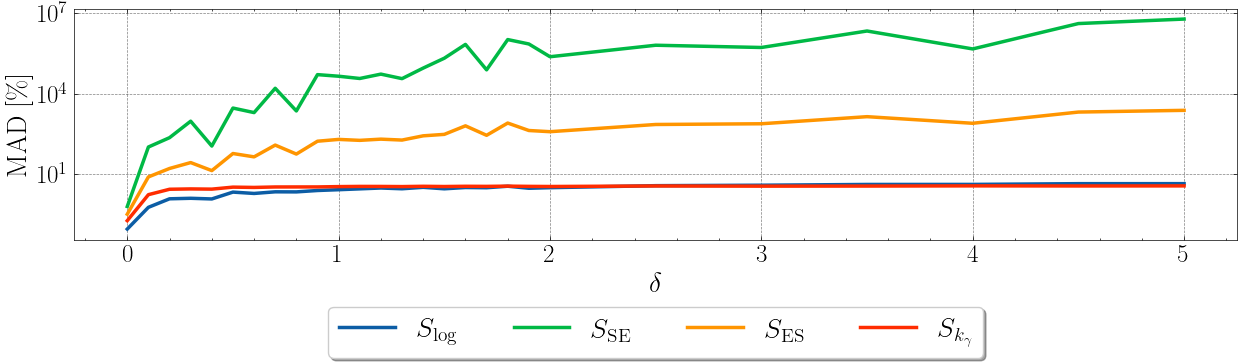

In [12]:
ens = 25
fig, axs = plt.subplots(1,1, figsize=(15,3))
for m,measure in enumerate(measures):
    axs.plot(df.columns.values,df.loc[(ens, measure)].values*100, label = names[m], lw = 2.5)
    
axs.set_yscale("log")
axs.xaxis.set_tick_params(labelsize=ticksize)
axs.yaxis.set_tick_params(labelsize=ticksize)

# Only include legend for yacht plot
if experiment == "yacht":
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23),
            fancybox=True, shadow=True, ncol=4, fontsize = legendsize)
    axs.set_xlabel(r"$\delta$", fontsize = labelsize)
axs.set_ylabel("MAD [\%]", fontsize = labelsize)

plt.savefig(f"../../plots/robustness_{experiment}.pdf", bbox_inches = "tight")